In [1]:
# https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-train-keras
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.ipynb
import numpy as np
import os
import matplotlib.pyplot as plt
import azureml
from azureml.core import Workspace
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)
ws = Workspace.from_config(path="config.json")
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Azure ML SDK Version:  1.0.55
Workspace name: Playground
Azure region: eastus2
Subscription id: 2980a959-c5f5-4c4c-9b7d-6182e368f102
Resource group: Team-Sudo-Code


In [2]:
from azureml.core import Experiment
script_folder = './azure2'
os.makedirs(script_folder, exist_ok=True)
exp = Experiment(workspace=ws, name='azure2')

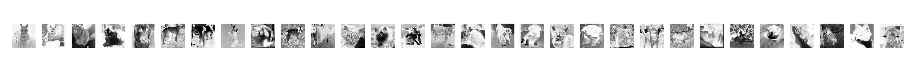

In [3]:
import numpy as np
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = np.load(os.path.join(os.path.dirname(os.getcwd()),"Azure-ML-2/data/features.npy"))
y_train = np.load(os.path.join(os.path.dirname(os.getcwd()),"Azure-ML-2/data/labels.npy"))
X_test=X_train[:20]
y_test=y_train[:20]

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
plt.style.use('dark_background')
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(100,100), cmap = plt.cm.Greys)
plt.show()

In [4]:
ds = ws.get_default_datastore()

In [5]:
# ds.upload(src_dir='./data', target_path='pets', overwrite=True, show_progress=True)

In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "cluster-nc6"
print("Cluster name:",cluster_name)

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Cluster name: cluster-nc6
Found existing compute target
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-08-12T01:59:21.305000+00:00', 'errors': None, 'creationTime': '2019-08-11T21:20:59.371321+00:00', 'modifiedTime': '2019-08-11T21:21:45.627369+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


In [7]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

cluster-nc6 AmlCompute Succeeded


In [8]:
with open(os.path.join(script_folder, 'train.py'), 'r') as f:
    print(f.read())

# python azure2/train.py --data-folder ./data
import numpy as np
import argparse
import os

import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

from azureml.core import Run

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neurons', typ

In [9]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ds.path('pets').as_mount()
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 pip_packages=['keras', 'matplotlib', 'numpy'],
                 entry_script='train.py',
                 use_gpu=True)

WARNING - framework_version is not specified, defaulting to version 1.13.


In [10]:
run = exp.submit(est)

In [11]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [ ]:
run.wait_for_completion(show_output=True)

RunId: azure2_1565575162_bd99c2a8
Web View: https://mlworkspace.azure.ai/portal/subscriptions/2980a959-c5f5-4c4c-9b7d-6182e368f102/resourceGroups/Team-Sudo-Code/providers/Microsoft.MachineLearningServices/workspaces/Playground/experiments/azure2/runs/azure2_1565575162_bd99c2a8

Streaming azureml-logs/70_driver_log.txt

Starting the daemon thread to refresh tokens in background for process with pid = 131
Using TensorFlow backend.
/azureml-envs/azureml_602f71f5f7d027fbe571ddf67bf1a969/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/azureml-envs/azureml_602f71f5f7d027fbe571ddf67bf1a969/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of nu

In [ ]:
run.get_metrics()

In [ ]:
# create a model folder in the current directory
os.makedirs('./model/original', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model/original', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

In [ ]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/original/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/original/model.h5")
print("Model loaded from disk.")

In [ ]:
# evaluate loaded model on test data
import keras
from keras.optimizers import Adam
loaded_model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
outputs=loaded_model.predict(X_test[:20])
predictions=[]
for prediction in outputs:
    predictions.append(prediction[0])
predictions=np.round(predictions,0).astype(int)
print(predictions[:20])
print(y_test[:20])

In [ ]:
print("Accuracy on the test set:", np.average(predictions==y_test))

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(32,64,128,256),
        '--second-layer-neurons': choice(32,64,128,256)
    }
)

In [ ]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': ds.path('pets').as_mount()},
                 compute_target=compute_target,
                 pip_packages=['keras', 'matplotlib'],
                 entry_script='train.py', 
                 use_gpu=True)

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

In [ ]:
hdc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='Accuracy', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=20,
                       max_concurrent_runs=4)

In [ ]:
hdr = exp.submit(config=hdc)

In [ ]:
RunDetails(hdr).show()

In [ ]:
hdr.wait_for_completion(show_output=True)

In [ ]:
best_run = hdr.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])

In [ ]:
print(best_run.get_file_names())

In [ ]:
model = best_run.register_model(model_name='playground-azure2', model_path='outputs/model')

In [ ]:
# create a model folder in the current directory
os.makedirs('./model/best', exist_ok=True)

for f in best_run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model/best', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        best_run.download_file(name=f, output_file_path=output_file_path)

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/best/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/best/model.h5")
print("Model loaded from disk.")

In [ ]:
# evaluate loaded model on test data
import keras
from keras.optimizers import Adam
loaded_model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
outputs=loaded_model.predict(X_test[:20])
predictions=[]
for prediction in outputs:
    predictions.append(prediction[0])
predictions=np.round(predictions,0).astype(int)
print(predictions[:20])
print(y_test[:20])

In [ ]:
print("Accuracy on the test set:", np.average(predictions==y_test))